In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras import models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import keras.utils as image
import os
import datetime
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

## Library

## Read in the data

In [2]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  'Data/Test1.v1i.folder/train',
  image_size=(128, 128),
  batch_size=32,
  label_mode = "int" 
  )

test_set = tf.keras.preprocessing.image_dataset_from_directory(
  'Data/Test1.v1i.folder/test',
  image_size=(128, 128),
  batch_size=32,
  label_mode = "int" 
  )

valid_set = tf.keras.preprocessing.image_dataset_from_directory(
  'Data/Test1.v1i.folder/val',
  image_size=(128, 128),
  batch_size=32,
  label_mode = "int" 
  )

Found 1296 files belonging to 2 classes.
Found 62 files belonging to 2 classes.
Found 124 files belonging to 2 classes.


Find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [3]:
class_names = train_set.class_names
print(class_names)

['A', 'S']


Here are the random nine images from the training dataset:

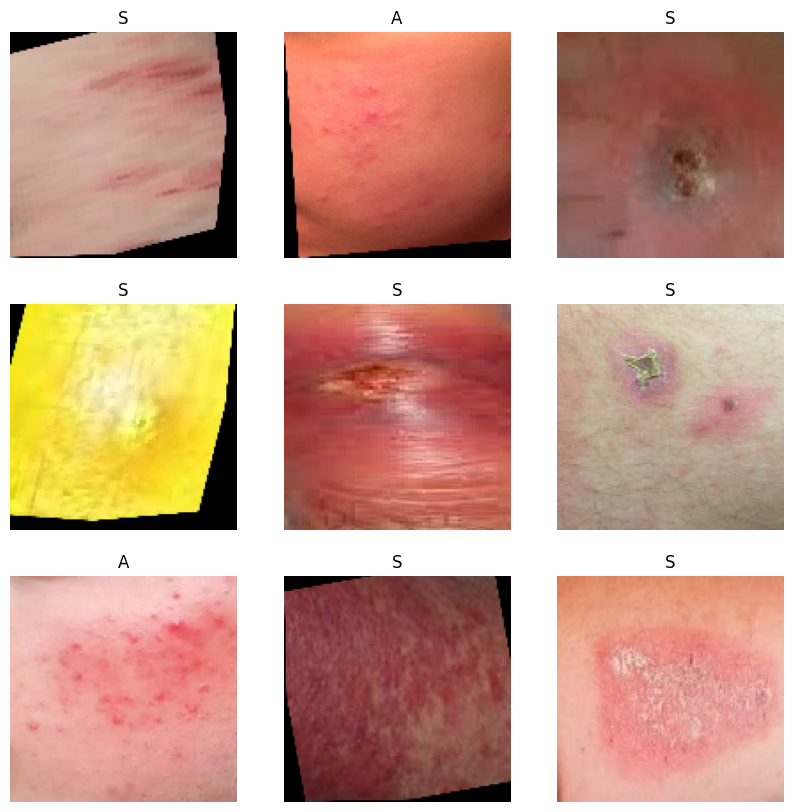

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

According to tf.keras.utils.image_dataset_from_directory document, labels should be sorted according to the alphanumeric order of the image file paths so: 

* Class A : 0

* Class S : 1

In [5]:
#The labels should match the smple images showed above
labels

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1])>

Check number of images for each class.

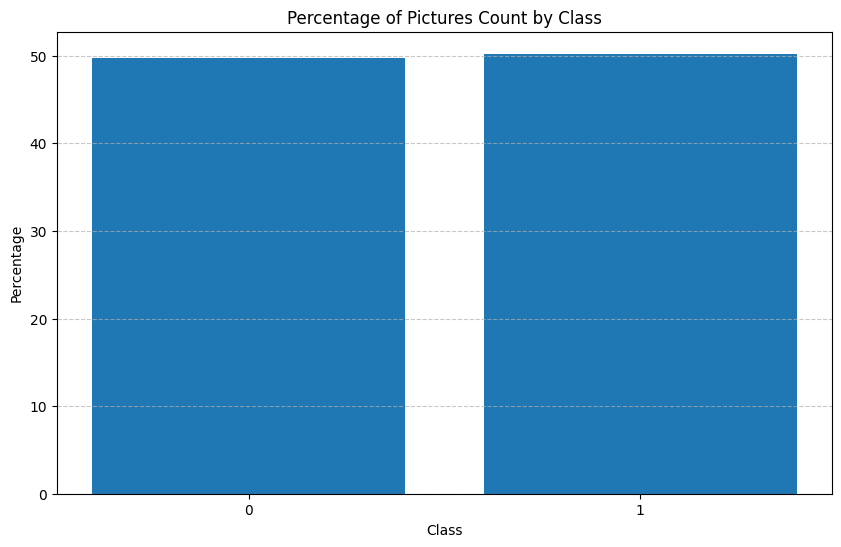

In [6]:
class_count_train = {}
for images, labels in train_set:
    for label in labels.numpy():
        if label not in class_count_train :
            class_count_train [label] = 1
        else:
            class_count_train [label] += 1

class_counts_df_train = {}

for images, labels in train_set:
    for label in labels.numpy():
        class_count_train[label] = class_count_train.get(label, 0) + 1
    
class_counts_df_train = pd.DataFrame(class_count_train .items(), columns=["Class", "Pictures Count"])

total_pictures = class_counts_df_train['Pictures Count'].sum()

# Calculate the percentage for each class and add it as a new column
class_counts_df_train['Percentage'] = (class_counts_df_train['Pictures Count'] / total_pictures) * 100

plt.figure(figsize=(10, 6))
plt.bar(class_counts_df_train['Class'], class_counts_df_train['Percentage'])
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Percentage of Pictures Count by Class')
plt.xticks(class_counts_df_train['Class'])  
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()

This is a batch of 32 images of shape 128x128x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [7]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


To enhance the performance

* train.cache(): Caches the elements of the dataset, which can improve the training speed by avoiding redundant data loading.

* .shuffle(1000): Shuffles the elements of the dataset with a buffer size of 1000. This randomizes the order of the data, which is beneficial during training.

* .prefetch(buffer_size=AUTOTUNE): Prefetches elements from the dataset to overlap the data loading and model execution. The buffer_size is set to the AUTOTUNE constant, allowing TensorFlow to determine an optimal value for parallelism.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = valid_set.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
num_classes = len(class_names)
num_classes

2

## Modeling

Function to plot the learning curve:

In [10]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

## Baseline Model - Sel-constructed CNN

In [15]:
log_dir = "logs/fit/" + "sel-constructed-cnn"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/sel-constructed-cnn", save_best_only=True)
early_stopping_callback_patience20 = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, start_from_epoch= 20)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.Dropout(0.4),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes, name="outputs")
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=[tensorboard_callback]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0

In [16]:

%load_ext tensorboard
%tensorboard --logdir logs/fit --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 4294967295).
Contents of stderr:
2024-02-02 09:27:03.458658: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
E0202 09:27:07.280346 17672 program.py:298] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use

In [13]:
max(model.history.history["val_accuracy"])

0.8145161271095276

In [14]:
model.save("Models\sel-constructed-cnn_model", save_format="tf")

INFO:tensorflow:Assets written to: cnn4_model\assets


INFO:tensorflow:Assets written to: cnn4_model\assets


## Xception

I load an Xception model, pretrained on ImageNet, and exclude the top of the network by setting include_top=False(This excludes the global average pooling layer and the dense output layer).

All of the trials use transfer learning with following:

Freeze the base model layers train for 5 epochs at 0.1 learning rate then unfreeze the layers for fine-tuning with early stoppping at 0.0001 learning rate.

Optimizar: SGD

Batch Size : 32

In [10]:
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

In [11]:
train_ds = (
    train_ds
    .map(lambda x, y: (preprocess (x), y))
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    val_ds
    .map(lambda x, y: (preprocess (x), y))
    .prefetch(tf.data.AUTOTUNE)
)
test_ds = (
    test_ds
    .map(lambda x, y: (preprocess (x), y))
    .prefetch(tf.data.AUTOTUNE)
)

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [13]:
base_model_xception = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

tf.random.set_seed(42)

#Average Pooling Layer
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model_xception.output)

#Dense Output Layer
output = tf.keras.layers.Dense(num_classes, name="outputs")(avg)

model = tf.keras.Model(inputs = base_model_xception.input, outputs = output)

Freeze the weights of the pretrained layers at the beginning of training.

In [14]:
for layer in base_model_xception.layers:
    layer.trainable = False

In [15]:
log_dir = "logs/fit/" + "xception"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/xception_checkpoint", save_best_only=True)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

initial_epoch = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=initial_epoch, 
  callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.4711 - accuracy: 0.7878

INFO:tensorflow:Assets written to: checkpoint\xception_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\xception_checkpoint\assets


41/41 [==============================] - 58s 1s/step - loss: 0.4711 - accuracy: 0.7878 - val_loss: 0.4396 - val_accuracy: 0.7903
Epoch 2/10
41/41 [==============================] - 108s 3s/step - loss: 0.3068 - accuracy: 0.8750 - val_loss: 0.4535 - val_accuracy: 0.7823
Epoch 3/10
41/41 [==============================] - ETA: 0s - loss: 0.2778 - accuracy: 0.8897

INFO:tensorflow:Assets written to: checkpoint\xception_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\xception_checkpoint\assets


41/41 [==============================] - 145s 4s/step - loss: 0.2778 - accuracy: 0.8897 - val_loss: 0.4058 - val_accuracy: 0.8306
Epoch 4/10
41/41 [==============================] - 120s 3s/step - loss: 0.2848 - accuracy: 0.8781 - val_loss: 0.4083 - val_accuracy: 0.8065
Epoch 5/10
41/41 [==============================] - 74s 2s/step - loss: 0.2711 - accuracy: 0.8873 - val_loss: 0.4070 - val_accuracy: 0.7984
Epoch 6/10
41/41 [==============================] - 40s 985ms/step - loss: 0.2343 - accuracy: 0.8997 - val_loss: 0.4101 - val_accuracy: 0.8226
Epoch 7/10
41/41 [==============================] - 41s 993ms/step - loss: 0.2026 - accuracy: 0.9151 - val_loss: 0.4085 - val_accuracy: 0.8226
Epoch 8/10
41/41 [==============================] - 41s 999ms/step - loss: 0.1958 - accuracy: 0.9236 - val_loss: 0.4119 - val_accuracy: 0.8065
Epoch 9/10
41/41 [==============================] - 41s 991ms/step - loss: 0.1959 - accuracy: 0.9282 - val_loss: 0.4958 - val_accuracy: 0.7984
Epoch 10/10
41/41

Fine-Tuning

The top layers are now pretty well trained, and I am ready to unfreeze some of the base model’s top layers, then continue training. I will unfreeze layers 116 and above (that’s the start of 13th residual unit) and use a much lower learning rate

In [16]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model_xception.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [17]:
for layer in base_model_xception.layers[116:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization): #Nornalization layer need to remain frozen
        layer.trainable = True

In [18]:
log_dir = "logs/fit/" + "xception_finetuning"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/xception_finetuning_checkpoint", save_best_only=True)
early_stopping_callback_patience20 = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, start_from_epoch= 20)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

fine_tune_epoch = 100
total_epoch =  initial_epoch + fine_tune_epoch

history_finetuning = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=total_epoch, 
  initial_epoch=history.epoch[-1],
  callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback_patience20]
)


Epoch 10/110
41/41 [==============================] - ETA: 0s - loss: 0.1601 - accuracy: 0.9421

INFO:tensorflow:Assets written to: checkpoint\xception_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\xception_finetuning_checkpoint\assets


41/41 [==============================] - 136s 3s/step - loss: 0.1601 - accuracy: 0.9421 - val_loss: 0.4132 - val_accuracy: 0.8306
Epoch 11/110
41/41 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.9483

INFO:tensorflow:Assets written to: checkpoint\xception_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\xception_finetuning_checkpoint\assets


41/41 [==============================] - 167s 4s/step - loss: 0.1541 - accuracy: 0.9483 - val_loss: 0.4131 - val_accuracy: 0.8226
Epoch 12/110
41/41 [==============================] - 111s 3s/step - loss: 0.1507 - accuracy: 0.9483 - val_loss: 0.4160 - val_accuracy: 0.8387
Epoch 13/110
41/41 [==============================] - 54s 1s/step - loss: 0.1417 - accuracy: 0.9475 - val_loss: 0.4244 - val_accuracy: 0.8065
Epoch 14/110
41/41 [==============================] - 56s 1s/step - loss: 0.1364 - accuracy: 0.9529 - val_loss: 0.4306 - val_accuracy: 0.8145
Epoch 15/110
41/41 [==============================] - 54s 1s/step - loss: 0.1318 - accuracy: 0.9537 - val_loss: 0.4239 - val_accuracy: 0.8226
Epoch 16/110
41/41 [==============================] - 53s 1s/step - loss: 0.1260 - accuracy: 0.9591 - val_loss: 0.4262 - val_accuracy: 0.8145
Epoch 17/110
41/41 [==============================] - 52s 1s/step - loss: 0.1202 - accuracy: 0.9599 - val_loss: 0.4267 - val_accuracy: 0.8468
Epoch 18/110
41/4

In [19]:
max(model.history.history["val_accuracy"])

0.8467742204666138

In [20]:
model.save("Models/xception_finetuning_model", save_format="tf")

INFO:tensorflow:Assets written to: Models/xception_finetuning_model\assets


INFO:tensorflow:Assets written to: Models/xception_finetuning_model\assets


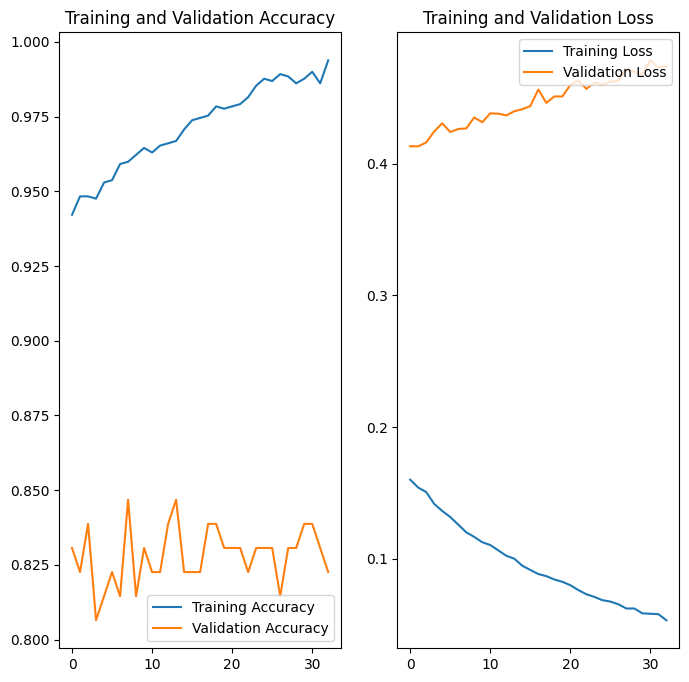

In [24]:
plot_training_history(history_finetuning)

## EfficientNetV2L

In [11]:
base_model_efficientnetv2l = tf.keras.applications.efficientnet_v2.EfficientNetV2L(weights="imagenet", include_top=False)

tf.random.set_seed(42)

#Average Pooling Layer
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model_efficientnetv2l.output)

#Dense Output Layer
output = tf.keras.layers.Dense(num_classes, name="outputs")(avg)

model = tf.keras.Model(inputs = base_model_efficientnetv2l.input, outputs = output)

Freeze the weights of the pretrained layers at the beginning of training.

In [12]:
for layer in base_model_efficientnetv2l.layers:
    layer.trainable = False

In [13]:
log_dir = "logs/fit/" + "efficientnetv2l"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/efficientnetv2l_checkpoint", save_best_only=True)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

initial_epoch = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=initial_epoch, 
  callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.5169 - accuracy: 0.7269

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_checkpoint\assets


41/41 [==============================] - 248s 6s/step - loss: 0.5169 - accuracy: 0.7269 - val_loss: 0.4387 - val_accuracy: 0.8145
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.3705 - accuracy: 0.8326

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_checkpoint\assets


41/41 [==============================] - 218s 5s/step - loss: 0.3705 - accuracy: 0.8326 - val_loss: 0.3920 - val_accuracy: 0.8548
Epoch 3/10
41/41 [==============================] - 105s 3s/step - loss: 0.3395 - accuracy: 0.8495 - val_loss: 0.3932 - val_accuracy: 0.8468
Epoch 4/10
41/41 [==============================] - ETA: 0s - loss: 0.3226 - accuracy: 0.8642

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_checkpoint\assets


41/41 [==============================] - 241s 6s/step - loss: 0.3226 - accuracy: 0.8642 - val_loss: 0.3894 - val_accuracy: 0.8548
Epoch 5/10
41/41 [==============================] - ETA: 0s - loss: 0.3045 - accuracy: 0.8719

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_checkpoint\assets


41/41 [==============================] - 308s 8s/step - loss: 0.3045 - accuracy: 0.8719 - val_loss: 0.3732 - val_accuracy: 0.8548
Epoch 6/10
41/41 [==============================] - ETA: 0s - loss: 0.2883 - accuracy: 0.8773

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_checkpoint\assets


41/41 [==============================] - 417s 10s/step - loss: 0.2883 - accuracy: 0.8773 - val_loss: 0.3683 - val_accuracy: 0.8548
Epoch 7/10
41/41 [==============================] - ETA: 0s - loss: 0.2851 - accuracy: 0.8858

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_checkpoint\assets


41/41 [==============================] - 475s 12s/step - loss: 0.2851 - accuracy: 0.8858 - val_loss: 0.3661 - val_accuracy: 0.8468
Epoch 8/10
41/41 [==============================] - 390s 10s/step - loss: 0.2799 - accuracy: 0.8912 - val_loss: 0.3752 - val_accuracy: 0.8629
Epoch 9/10
41/41 [==============================] - 469s 11s/step - loss: 0.2653 - accuracy: 0.8958 - val_loss: 0.3750 - val_accuracy: 0.8548
Epoch 10/10
41/41 [==============================] - ETA: 0s - loss: 0.2547 - accuracy: 0.8935

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_checkpoint\assets


41/41 [==============================] - 747s 18s/step - loss: 0.2547 - accuracy: 0.8935 - val_loss: 0.3659 - val_accuracy: 0.8306


In [14]:
model.save("efficientnetv2l_base", save_format = "tf")

INFO:tensorflow:Assets written to: efficientnetv2l_base\assets


INFO:tensorflow:Assets written to: efficientnetv2l_base\assets


In [22]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model_efficientnetv2l.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block2b_project_bn     66: block2g_expand_activation 99: block3e_expand_activation
  1: rescaling              34: block2b_drop           67: block2g_project_conv  100: block3e_project_conv  
  2: stem_conv              35: block2b_add            68: block2g_project_bn    101: block3e_project_bn    
  3: stem_bn                36: block2c_expand_conv    69: block2g_drop          102: block3e_drop          
  4: stem_activation        37: block2c_expand_bn      70: block2g_add           103: block3e_add           
  5: block1a_project_conv   38: block2c_expand_activation 71: block3a_expand_conv   104: block3f_expand_conv   
  6: block1a_project_bn     39: block2c_project_conv   72: block3a_expand_bn     105: block3f_expand_bn     
  7: block1a_project_activation 40: block2c_project_bn     73: block3a_expand_activation106: block3f_expand_activation
  8: block1a_add            41: block2c_drop           74: block3a_project_conv  107: block3f_project_conv  


Fine-Tuning

I will unfreeze layers 118 and above and use a much lower learning rate

In [16]:
for layer in base_model_efficientnetv2l.layers[118:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization): #Nornalization layer need to remain frozen
        layer.trainable = True

In [17]:
log_dir = "logs/fit/" + "efficientnetv2l_finetuning"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/efficientnetv2l_finetuning_checkpoint", save_best_only=False, monitor= "val_loss", save_freq='epoch')
early_stopping_callback_patience20 = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, start_from_epoch= 10)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

fine_tune_epoch = 100
total_epoch =  initial_epoch + fine_tune_epoch

history_finetuning = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=total_epoch, 
  initial_epoch=history.epoch[-1],
  callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback_patience20]
)

Epoch 10/110
41/41 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.8958 

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 2320s 56s/step - loss: 0.2628 - accuracy: 0.8958 - val_loss: 0.3574 - val_accuracy: 0.8468
Epoch 11/110
41/41 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9144 

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 2771s 68s/step - loss: 0.2246 - accuracy: 0.9144 - val_loss: 0.3402 - val_accuracy: 0.8710
Epoch 12/110
41/41 [==============================] - ETA: 0s - loss: 0.2111 - accuracy: 0.9182  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 2963s 73s/step - loss: 0.2111 - accuracy: 0.9182 - val_loss: 0.3350 - val_accuracy: 0.8629
Epoch 13/110
41/41 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9421  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 3099s 76s/step - loss: 0.1798 - accuracy: 0.9421 - val_loss: 0.3148 - val_accuracy: 0.8871
Epoch 14/110
41/41 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.9383 

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 2206s 54s/step - loss: 0.1617 - accuracy: 0.9383 - val_loss: 0.3175 - val_accuracy: 0.8871
Epoch 15/110
41/41 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.9491 

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 2155s 53s/step - loss: 0.1429 - accuracy: 0.9491 - val_loss: 0.3132 - val_accuracy: 0.9032
Epoch 16/110
41/41 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.9545 

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 1972s 48s/step - loss: 0.1407 - accuracy: 0.9545 - val_loss: 0.3067 - val_accuracy: 0.9032
Epoch 17/110
41/41 [==============================] - ETA: 0s - loss: 0.1199 - accuracy: 0.9614 

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 1842s 45s/step - loss: 0.1199 - accuracy: 0.9614 - val_loss: 0.3121 - val_accuracy: 0.9032
Epoch 18/110
41/41 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9684 

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 1977s 48s/step - loss: 0.1094 - accuracy: 0.9684 - val_loss: 0.3060 - val_accuracy: 0.9032
Epoch 19/110
41/41 [==============================] - ETA: 0s - loss: 0.0990 - accuracy: 0.9676 

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 2021s 49s/step - loss: 0.0990 - accuracy: 0.9676 - val_loss: 0.3125 - val_accuracy: 0.9032
Epoch 20/110
41/41 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.9738 

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 2120s 52s/step - loss: 0.0860 - accuracy: 0.9738 - val_loss: 0.3083 - val_accuracy: 0.8952
Epoch 21/110
41/41 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9715  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 4648s 115s/step - loss: 0.0874 - accuracy: 0.9715 - val_loss: 0.3085 - val_accuracy: 0.9032
Epoch 22/110
41/41 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9838  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 2848s 68s/step - loss: 0.0664 - accuracy: 0.9838 - val_loss: 0.3089 - val_accuracy: 0.9113
Epoch 23/110
41/41 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9776 

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 2614s 64s/step - loss: 0.0694 - accuracy: 0.9776 - val_loss: 0.3106 - val_accuracy: 0.8871
Epoch 24/110
41/41 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9830  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 4377s 107s/step - loss: 0.0580 - accuracy: 0.9830 - val_loss: 0.3183 - val_accuracy: 0.8952
Epoch 25/110
41/41 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9861  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 3435s 83s/step - loss: 0.0516 - accuracy: 0.9861 - val_loss: 0.3166 - val_accuracy: 0.9032
Epoch 26/110
41/41 [==============================] - ETA: 0s - loss: 0.0493 - accuracy: 0.9869 

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 2422s 59s/step - loss: 0.0493 - accuracy: 0.9869 - val_loss: 0.3147 - val_accuracy: 0.9113
Epoch 27/110
41/41 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9884  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 2753s 67s/step - loss: 0.0444 - accuracy: 0.9884 - val_loss: 0.3165 - val_accuracy: 0.8871
Epoch 28/110
41/41 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9946  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 2860s 70s/step - loss: 0.0382 - accuracy: 0.9946 - val_loss: 0.3268 - val_accuracy: 0.9113
Epoch 29/110
41/41 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9892  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 2752s 67s/step - loss: 0.0380 - accuracy: 0.9892 - val_loss: 0.3219 - val_accuracy: 0.8952
Epoch 30/110
41/41 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9938  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 3039s 74s/step - loss: 0.0326 - accuracy: 0.9938 - val_loss: 0.3186 - val_accuracy: 0.9113
Epoch 31/110
41/41 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9946  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 2919s 71s/step - loss: 0.0320 - accuracy: 0.9946 - val_loss: 0.3157 - val_accuracy: 0.9113
Epoch 32/110
41/41 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9946  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 3062s 75s/step - loss: 0.0279 - accuracy: 0.9946 - val_loss: 0.3230 - val_accuracy: 0.9113
Epoch 33/110
41/41 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 0.9946  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 3052s 75s/step - loss: 0.0289 - accuracy: 0.9946 - val_loss: 0.3310 - val_accuracy: 0.9113
Epoch 34/110
41/41 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9915  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 3005s 73s/step - loss: 0.0256 - accuracy: 0.9915 - val_loss: 0.3227 - val_accuracy: 0.8952
Epoch 35/110
41/41 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9961  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 3295s 81s/step - loss: 0.0201 - accuracy: 0.9961 - val_loss: 0.3315 - val_accuracy: 0.9032
Epoch 36/110
41/41 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9954  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 3092s 76s/step - loss: 0.0230 - accuracy: 0.9954 - val_loss: 0.3381 - val_accuracy: 0.9113
Epoch 37/110
41/41 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9915  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 3315s 81s/step - loss: 0.0263 - accuracy: 0.9915 - val_loss: 0.3334 - val_accuracy: 0.8790
Epoch 38/110
41/41 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9969  

INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\efficientnetv2l_finetuning_checkpoint\assets


41/41 [==============================] - 5501s 136s/step - loss: 0.0175 - accuracy: 0.9969 - val_loss: 0.3309 - val_accuracy: 0.9032


In [20]:
max(model.history.history["val_accuracy"])

0.9112903475761414

In [18]:
model.save("Models\efficientnetv2l_finetuning_model", save_format="tf")

INFO:tensorflow:Assets written to: Models\efficientnetv2l_finetuning_model\assets


INFO:tensorflow:Assets written to: Models\efficientnetv2l_finetuning_model\assets


## YOLO

In [ ]:
%pip install ultralytics

In [1]:
import ultralytics
ultralytics.checks()

from ultralytics import YOLO

Ultralytics YOLOv8.1.2 🚀 Python-3.11.4 torch-2.0.1+cpu CPU (13th Gen Intel Core(TM) i9-13900H)
Setup complete ✅ (20 CPUs, 31.6 GB RAM, 396.3/451.4 GB disk)


In [ ]:

# Load a model
model = YOLO('Models\yolo_pretrained\yolov8x-cls.pt') # load a pretrained model (recommended for training)

# Train the model
model.train(data='Data\Test1.v1i.folder', 
            epochs=100, batch = 32, 
            imgsz = 128, 
            verbose = True, 
            patience = 20, 
            save = True,
            seed = 420, 
            val = True, 
            plots = True)

In [3]:
yolov8_result = pd.read_csv("runs/classify/train/results.csv")
yolov8_result.sort_values(by="  metrics/accuracy_top1", ascending=False)

,epoch,train/loss,metrics/accuracy_top1,metrics/accuracy_top5,val/loss,lr/pg0,lr/pg1,lr/pg2
67,68,0.01867,0.93548,1,0.38345,0.000247,0.000247,0.000247
83,84,0.01196,0.92742,1,0.39005,0.000134,0.000134,0.000134
75,76,0.01307,0.92742,1,0.39294,0.000191,0.000191,0.000191
87,88,0.01297,0.92742,1,0.39176,0.000106,0.000106,0.000106
84,85,0.00636,0.91935,1,0.39078,0.000127,0.000127,0.000127
...,...,...,...,...,...,...,...,...
5,6,0.17675,0.83871,1,0.46120,0.000686,0.000686,0.000686
4,5,0.22721,0.83871,1,0.47829,0.000693,0.000693,0.000693
13,14,0.10905,0.83871,1,0.46030,0.000629,0.000629,0.000629
30,31,0.04524,0.83871,1,0.44921,0.000509,0.000509,0.000509


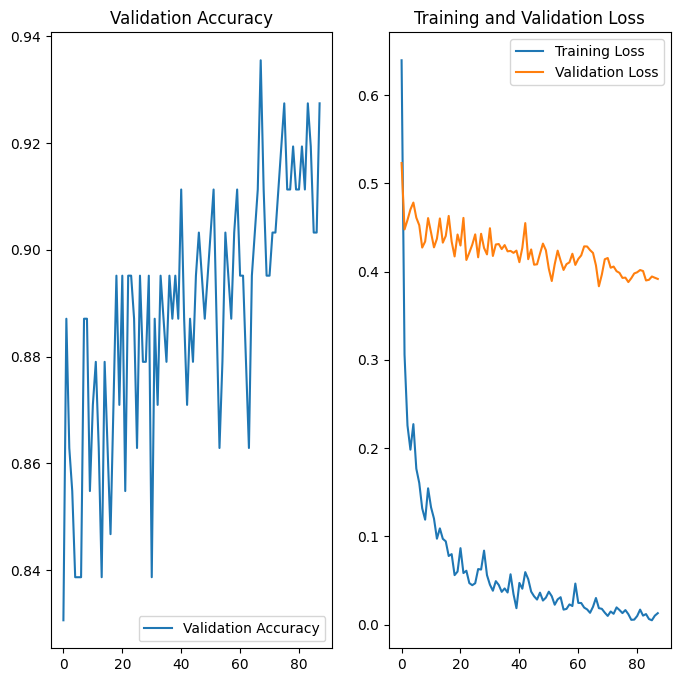

In [4]:
val_acc = yolov8_result["  metrics/accuracy_top1"]

loss = yolov8_result["             train/loss"]
val_loss = yolov8_result["               val/loss"]

plt.figure(figsize=(8, 8))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [6]:
#If want to load the model and resume training

#model = YOLO('runs/classify/train\weights/last.pt')  